In [1]:
# this main code by Ssamot from https://github.com/ssamot/infoGA/blob/master/mnist_snes_example.py
# plot loss function from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# loading data office-31 from Lyu Chaofan 1706987

import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from dataSet import dataSet
from timeit import default_timer as timer
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from keras_helper import NNWeightHelper
from snes import SNES

Using TensorFlow backend.


In [2]:
def train_classifier(model, X, y):
    X_features = model.predict(X)
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred
def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)


In [3]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 31

# use just a small sample of the train set to test
SAMPLE_SIZE = 300
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 10
# how many times we will loop over ask()/tell()
GENERATIONS = 30


In [4]:
Amazon_path = './Original_images/amazon/images'
dslr_path   = './Original_images/dslr/images'
webcam_path = './Original_images/webcam/images'

paths = [Amazon_path, dslr_path, webcam_path]
files = os.listdir(Amazon_path)
labels = {}
count  = 0
for key in files:
    a = {key : count}
    labels.update(a)
    count += 1
# print (labels)

images_path = []
Amazon = dataSet()
webcam = dataSet()

In [5]:
for dirname in files:
    images_name = os.listdir(Amazon_path + '/' + dirname)
    for name in images_name:
        Image_Path = Amazon_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        Amazon.upData(image_data, labels[dirname], labels)
Amazon.sHape()


In [6]:
for dirname in files:
    images_name = os.listdir(webcam_path + '/' + dirname)
    for name in images_name:
        Image_Path = webcam_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        webcam.upData(image_data, labels[dirname], labels)
        
webcam.sHape()

In [7]:
#label classifier data
x_train = Amazon.data
y_train = Amazon.label
x_test  = webcam.data
y_test  = webcam.label

In [8]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# data for domain classifier
x_domain = np.concatenate((x_train,x_test), axis = 0)
y_domain = np.concatenate((np.zeros(y_train.shape[0]), np.ones(y_test.shape[0])),axis = 0)


In [9]:
# Neural network architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',
                 input_shape=(28,28,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))

# this is irrelevant for what we want to achieve
model.compile(loss="mse", optimizer="adam")
print("compilation is over")
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

compilation is over


In [10]:
print("Total number of weights to evolve is:", weights.shape)
all_examples_indices = list(range(x_train.shape[0]))
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)

test_accuracy = accuracy_score(y_test, y_pred)
print('Non-trained NN Test accuracy:', test_accuracy)
# print('Test MSE:', test_mse)

snes = SNES(weights, 1, POPULATION_SIZE)
p = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []

    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])
        # train the domain classifier and get back the predictions on the training data
        clf2, _ = train_classifier(model, x_domain[subsample_indices], y_domain[subsample_indices])
        
        # calculate the label predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        # calculate the domain predictions on a different set
        y_pred1 = predict_classifier(model, clf, x_domain[subsample_indices_valid])
        score1 = accuracy_score(y_domain[subsample_indices_valid], y_pred1)
        total = (score+(2*-score1))
        told.append(total)

    temp = snes.tell(asked, told)
    p.append(temp)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)
    
nnw.set_weights(snes.center)

# predict on source data
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_train)
test_accuracy = accuracy_score(y_train, y_pred)
print('Test accuracy on source:', test_accuracy)

# predict on target data

y_pred1 = predict_classifier(model, clf, x_test)
test_accuracy1 = accuracy_score(y_test, y_pred1)
print('Test accuracy on target:', test_accuracy1)

Total number of weights to evolve is: (53714,)


Non-trained NN Test accuracy: 0.05911949685534591


Step 1.0 : 0.1362126245847176 best: 0.1362126245847176 10
It took 5.430000835701448 seconds to complete generation 1


Step 2.0 : 0.1661129568106312 best: 0.1661129568106312 10
It took 5.3279507577908 seconds to complete generation 2


Step 3.0 : 0.19601328903654486 best: 0.19601328903654486 10
It took 6.3924432842573236 seconds to complete generation 3


Step 4.0 : 0.17275747508305647 best: 0.19601328903654486 10
It took 6.1958908877159296 seconds to complete generation 4


Step 5.0 : 0.1727574750830565 best: 0.19601328903654486 10
It took 5.894145188492992 seconds to complete generation 5


Step 6.0 : 0.1760797342192691 best: 0.19601328903654486 10
It took 5.7482204319483365 seconds to complete generation 6


Step 7.0 : 0.14950166112956811 best: 0.19601328903654486 10
It took 5.5075877812690734 seconds to complete generation 7


Step 8.0 : 0.2225913621262458 best: 0.2225913621262458 10
It took 6.007514613315294 seconds to complete generation 8


Step 9.0 : 0.2259136212624585 best: 0.2259136212624585 10
It took 5.4536959689922995 seconds to complete generation 9


Step 10.0 : 0.1461794019933555 best: 0.2259136212624585 10
It took 5.635946587041126 seconds to complete generation 10


Step 11.0 : 0.186046511627907 best: 0.2259136212624585 10
It took 5.568771353141685 seconds to complete generation 11


Step 12.0 : 0.20930232558139533 best: 0.2259136212624585 10
It took 5.514869667598866 seconds to complete generation 12


Step 13.0 : 0.2790697674418605 best: 0.2790697674418605 10
It took 5.425498978998505 seconds to complete generation 13


Step 14.0 : 0.20930232558139536 best: 0.2790697674418605 10
It took 5.453423748942598 seconds to complete generation 14


Step 15.0 : 0.24252491694352157 best: 0.2790697674418605 10
It took 5.373731329389429 seconds to complete generation 15


Step 16.0 : 0.1760797342192691 best: 0.2790697674418605 10
It took 5.29598676418162 seconds to complete generation 16


Step 17.0 : 0.15614617940199338 best: 0.2790697674418605 10
It took 5.285094788643349 seconds to complete generation 17


Step 18.0 : 0.17940199335548174 best: 0.2790697674418605 10
It took 5.29525578987716 seconds to complete generation 18


Step 19.0 : 0.11627906976744184 best: 0.2790697674418605 10
It took 5.2945939284350345 seconds to complete generation 19


Step 20.0 : 0.15614617940199335 best: 0.2790697674418605 10
It took 5.292382316839451 seconds to complete generation 20


Step 21.0 : 0.16611295681063123 best: 0.2790697674418605 10
It took 5.287496460610427 seconds to complete generation 21


Step 22.0 : 0.2292358803986711 best: 0.2790697674418605 10
It took 5.309010307337147 seconds to complete generation 22


Step 23.0 : 0.13289036544850497 best: 0.2790697674418605 10
It took 5.326102341339251 seconds to complete generation 23


Step 24.0 : 0.20598006644518274 best: 0.2790697674418605 10
It took 5.484460360776183 seconds to complete generation 24


Step 25.0 : 0.1926910299003322 best: 0.2790697674418605 10
It took 5.824186046183627 seconds to complete generation 25


Step 26.0 : 0.1661129568106312 best: 0.2790697674418605 10
It took 5.518566147885309 seconds to complete generation 26


Step 27.0 : 0.16943521594684385 best: 0.2790697674418605 10
It took 5.42807061218835 seconds to complete generation 27


Step 28.0 : 0.1395348837209302 best: 0.2790697674418605 10
It took 5.452993556636045 seconds to complete generation 28


Step 29.0 : 0.16943521594684385 best: 0.2790697674418605 10
It took 5.3574697075855795 seconds to complete generation 29


Step 30.0 : 0.19269102990033224 best: 0.2790697674418605 10
It took 5.356565598508581 seconds to complete generation 30


Test accuracy on source: 0.9971600993965212


Test accuracy on target: 0.05786163522012579


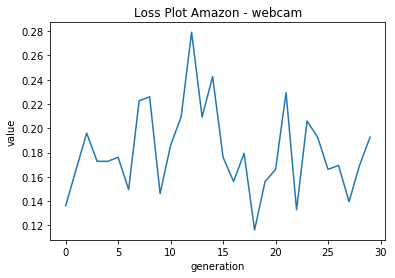

In [11]:
plt.plot(p)
plt.title('Loss Plot Amazon - webcam')
plt.xlabel('generation')
plt.ylabel('value')
plt.savefig('Plot_amazon_webcam.png')
plt.show()